##  Modeling the Impact of Lateral Flow Parameterizations on Basin Wide Runoff in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the lateral flux of liquid water on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at the sensitivity of the different model representation of the lateral flux of liquid water, which determines the availability of soil water.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the latertal flux from the soil profile are described. Next, the Methods section describes how the pySUMMA can be used to create three different lateral model representation of the Reynolds Mountain East catchment model, 1d Richards', lumped topmodel, and distributed topmodel. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 8(right) from Clark et al. (2015).

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

 |                    Method                   | 1dRichards' |   Lumped Topmodel |   Distributed Topmodel |
 |---------------------------------------------|-------------|-------------------|------------------------|
 |         groundwater parameterization        | noXplict    | qTopmodl          | qTopmodl               |
 |       hydraulic conductivity profile        | constant    | pow_prof          | pow_prof               |
 |lower boundary condition for soil hydrology  | drainage    | zeroFlux          | zeroFlux               |
 |thermal conductivity representation for soil | mixConstit  | funcSoilWet       | funcSoilWet            |

## 2. Background

### The Transpiration from soil layers available in SUMMA

In [159]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### Latertal flux from the soil profile

The soil columns can be hydrologically connected, such that the lateral flux from upslope soil columns is the inflow to downslope soil columns, or hydrologically-disconnected (using one or many soil columns), in which case the lateral flux of water from soil columns is assumed to flow directly into the river network.

The continuity equation for sub-surface storage (i.e., below the water table) can be written for a given model element as [Wigmosta et al., 1994]

\begin{equation*}
Q_{dr} = \frac{dz_{wt}}{dt} = \frac{Q_{out}-Q_{in}}{A} - q_{rchg}
\end{equation*}

$Q_{dr} = (\theta_{sat}^{soil} - \theta_{fc}^{soil}) $ : “drainable” porosity, $\theta_{fc}^{soil}$ : the field capacity of soil, $z_{wt}$ $(m)$ : the depth to the water table

$Q_{out}$ and $Q_{in}$ $(m^{3}/s)$: the lateral inflow and outflow, $q_{rchg}$ $(m/s)$ : the vertical recharge rate, $A$ $(m^2)$ : the element area

#### Storage-based implementation to represent lateral flow between soil columns

The “drainable” water storage and the maximum drainable water storage can be given as
\begin{equation*}
W_{dr}^{soil} = \int_{z_{crit}}^{z_{soil}}\ [\theta_{liq}^{soil} (z) - \theta_{fc}^{soil} ] \mathrm{d}z, \          W_{dr,max}^{soil} = \phi_{dr}z_{soil}
\end{equation*}

$\theta_{liq}^{soil} (z)$ : the volumetric liquid water content at soil depth z, $z_{crit}$ : the lowest point in the soil profile where $\theta_{liq}^{soil}$ < $\theta_{fc}^{soil}$

#### The total lateral outflow

\begin{equation*}
Q_{out} = x_{len}tan(\beta) \frac{K_{sat}^{0} W_{dr,max}^{soil}}{\phi_{dr}n_{sf}}[\frac{W_{dr}^{soil}}{W_{dr,max}^{soil}}]^{n_{sf}}
\end{equation*}

$\beta$ : the gradient in the land surface, used to approximate the water table gradient

#### The total lateral flux

\begin{equation*}
q_{base}^{soil} =  \frac{Q_{out}-Q_{in}}{A}
\end{equation*}

The total lateral flux $q_{base}^{soil}$ can then be apportioned to individual soil layers, obtained after spatial discretization described in Clark et al. [2015b], to provide the lateral flow sink term

\begin{equation*}
(S_{lf})_{j} = (w_{tv})_{j}   q_{base}^{soil}
\end{equation*}

$(w_{tv})_{j}$ : the ratio of the transmissivity of the $j$-th layer to the total transmissivity

The above descriptions are taken from the lateral flux from the soil profile section(3.2.3.5) within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [3]:
from ipyleaflet import Map, GeoJSON
import json

In [4]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[43.06745, -116.75489], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), GeoJSON(data={'type': 'FeatureCollection', 'name': 'reynolds_geojson_latlon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'OBJECTID': 1, 'RCEW_REGIO': 376208.194027, 'PERIMETER': 3340.0, 'RMEAST_MAS': 2, 'RMEAST_M_1': 2, 'GRID_CODE': 1}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-116.7557156288284, 43.07072983625339], [-116.75559279969227, 43.07072957489522], [-116.75559315872648, 43.07063952502811], [-116.75547032977175, 43.07063926353894], [-116.75534750204696, 43.07063900192053], [-116.75522467432737, 43.07063873926983], [-116.7551018453776, 43.07063847738518], [-116.75510220512943, 43.0705484275199], [-116.75497937636112, 43.07054816550426], [-116.75497973629112, 43.070458115638395], [-116.75485690770425, 43.07045785349174], [-116.7547340803473, 43.07045759121584], [-116.754611252992, 43.070457328808125], [-116.75448842441011, 43.07045706626597], [-116.75436559706174, 43.070456802694125], [-116.75424276848315, 43.07045653988829], [-116.75424312949033, 43.070366490025975], [-116.75412030232148, 43.070366227091775], [-116.75399747392602, 43.0703659640231], [-116.75399783529119, 43.07027591416101], [-116.75387500707716, 43.07027565096134], [-116.7537521800931, 43.07027538763253], [-116.75362935188241, 43.07027512416918], [-116.75362971378532, 43.07018507430818], [-116.75363007445833, 43.07009502444305], [-116.75363043635795, 43.07000497457918], [-116.75363079702761, 43.06991492471125], [-116.75375362451547, 43.06991518907176], [-116.75375398500368, 43.06982513920156], [-116.75375434671845, 43.06973508933261], [-116.75375470720336, 43.06964503945952], [-116.75363188147955, 43.06964477600465], [-116.7536322421426, 43.069554726130995], [-116.75350941660027, 43.06955446254514], [-116.75350977744145, 43.06946441267091], [-116.75338695208056, 43.06946414895402], [-116.75338731309988, 43.0693740990792], [-116.75326448792045, 43.06937383523132], [-116.75326485034614, 43.06928378535855], [-116.75314202411995, 43.06928352137701], [-116.75301919912368, 43.069283257266314], [-116.75301956067906, 43.06919320739113], [-116.753019923461, 43.06910315751716], [-116.75289709759774, 43.069102893273666], [-116.7527742729644, 43.06910262890097], [-116.75277463610426, 43.06901257902725], [-116.75265181042415, 43.069012314520926], [-116.75265217374212, 43.06892226464661], [-116.75252934824346, 43.06892200000929], [-116.75252971173958, 43.06883195013435], [-116.7525300740058, 43.0687419002554], [-116.75240725009662, 43.068741635490554], [-116.75240761254095, 43.06865158561097], [-116.75240797621186, 43.06856153573259], [-116.75240833865288, 43.06847148585014], [-116.7524087023168, 43.06838143686942], [-116.75228587790387, 43.06838117107297], [-116.75228624174592, 43.068291122091665], [-116.7522866043617, 43.068201072205795], [-116.75228696820399, 43.06811102232113], [-116.75228733081644, 43.06802097243243], [-116.75228769465541, 43.067930922544896], [-116.75228805726088, 43.067840873553784], [-116.75228842109648, 43.06775082366344], [-116.75216559794013, 43.06775055864152], [-116.75216596195388, 43.06766050875055], [-116.75204313897898, 43.06766024359765], [-116.75192031723756, 43.067659977415076], [-116.7517974954942, 43.067659712001166], [-116.75167467252432, 43.06765944645277], [-116.75167503725551, 43.06756939656374], [-116.75167540075684, 43.067479346670616], [-116.75167576548104, 43.067389297679235], [-116.75167612897903, 43.06729924778324], [-116.75155330795809, 43.067298982109065], [-116.75155367163417, 43.06720893221254], [-116.75155403653679, 43.06711888231719], [-116.7515544002095, 43.06702883241775

### 2) Download TestCases and Installation to prepare SUMMA simulation

In [ ]:
# import utils.py to download TestCases from web, unzip and installation
from pysumma.utils import install_test_cases

In [5]:
# assign the directory to save and unzip
directory = '/media/sf_pysumma/'

In [1]:
# install TestCase to run SUMMA model
install_test_cases(directory)

NameError: name 'install_test_cases' is not defined

### 3) Create pySUMMA Simulation Object of 1d Richards method and Run SUMMA Model

In [6]:
from pysumma.Simulation import Simulation
from pysumma.Plotting import Plotting

In [7]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_1dRichards = Simulation(directory + 'summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_1dRichards.txt')

In [8]:
# check the simulation start and finish times
S_1dRichards.decision_obj.simulStart.value, S_1dRichards.decision_obj.simulFinsh.value

('2002-07-01 00:00', '2008-09-30 00:00')

In [9]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_1dRichards.decision_obj.groundwatr.options, S_1dRichards.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'noXplict')

In [10]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_1dRichards.decision_obj.hc_profile.options, S_1dRichards.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'constant')

In [11]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_1dRichards.decision_obj.bcLowrSoiH.options, S_1dRichards.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'drainage')

In [12]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_1dRichards.decision_obj.thCondSoil.options, S_1dRichards.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'mixConstit')

In [13]:
# check Basin variable meta data in file manager file
S_1dRichards.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [14]:
# check Basin Parameter info data in file manager file
S_1dRichards.basin_par.filename

'summa_zBasinParamInfo.txt'

In [15]:
# check Forcing list data in file manager file
S_1dRichards.forcing_list.filename

'summa_zForcingFileList_riparianAspen_1dRichards.txt'

In [16]:
# check Initial condition data in file manager file
S_1dRichards.initial_cond.filename

'summa_zInitialCond.nc'

In [17]:
# run the model giving the output the suffix "1dRichards_docker_develop" and get "results_1dRichards" object
results_1dRichards = S_1dRichards.execute(run_suffix="1dRichards_docker_develop", run_option = 'docker_develop')

### 4) Create pySUMMA Simulation Object of Lumped Topmodel method and Run SUMMA Model

In [18]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_lumpedTopmodel = Simulation(directory + 'summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_lumpedTopmodel.txt')

In [19]:
# check the simulation start and finish times
S_lumpedTopmodel.decision_obj.simulStart.value, S_lumpedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [20]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_lumpedTopmodel.decision_obj.groundwatr.options, S_lumpedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [21]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_lumpedTopmodel.decision_obj.hc_profile.options, S_lumpedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [22]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_lumpedTopmodel.decision_obj.bcLowrSoiH.options, S_lumpedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [23]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_lumpedTopmodel.decision_obj.thCondSoil.options, S_lumpedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [24]:
# check Basin variable meta data in file manager file
S_lumpedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [25]:
# check Basin Parameter info data in file manager file
S_lumpedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [26]:
# check Forcing list data in file manager file
S_lumpedTopmodel.forcing_list.filename

'summa_zForcingFileList_riparianAspen_lumpedTopmodel.txt'

In [27]:
# check Initial condition data in file manager file
S_lumpedTopmodel.initial_cond.filename

'summa_zInitialCond.nc'

In [28]:
# run the model giving the output the suffix "lumpedTopmodel_docker_develop" and get "results_lumpedTopmodel" object
results_lumpedTopmodel = S_lumpedTopmodel.execute(run_suffix="lumpedTopmodel_docker_develop", run_option = 'docker_develop')

### 5) Create pySUMMA Simulation Object of Distributed Topmodel method and Run SUMMA Model

In [29]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_distributedTopmodel = Simulation(directory + 'summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_distributedTopmodel.txt')

In [30]:
# check the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value, S_distributedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [31]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_distributedTopmodel.decision_obj.groundwatr.options, S_distributedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [32]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_distributedTopmodel.decision_obj.hc_profile.options, S_distributedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [33]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_distributedTopmodel.decision_obj.bcLowrSoiH.options, S_distributedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [34]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_distributedTopmodel.decision_obj.thCondSoil.options, S_distributedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [35]:
# check Basin variable meta data in file manager file
S_distributedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [36]:
# check Basin Parameter info data in file manager file
S_distributedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [37]:
# check Forcing list data in file manager file
S_distributedTopmodel.forcing_list.filename

'summa_zForcingFileList_fullDist.txt'

In [38]:
# check Initial condition data in file manager file
S_distributedTopmodel.initial_cond.filename

'summa_zInitialCond_disTop.nc'

In [39]:
# run the model giving the output the suffix "distributedTopmodel_docker_develop" and get "results_distributedTopmodel" object
results_distributedTopmodel = S_distributedTopmodel.execute(run_suffix="distributedTopmodel_docker_develop", run_option = 'docker_develop')

## 4. Results

### Recreate the Figure 8(right) plot from Clark et al., 2015: The total ET Sensitivity for the model representation of the lateral flux of liquid water

In [40]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

In [55]:
results_1dRichards['averageInstantRunoff']

<xarray.DataArray 'averageInstantRunoff' (time: 54793, gru: 1)>
array([[8.699404e-13],
       [8.699404e-13],
       [8.699404e-13],
       ...,
       [3.518281e-10],
       [3.512762e-10],
       [3.507260e-10]])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-01 2002-07-01T00:59:59.999986560 ...
Dimensions without coordinates: gru
Attributes:
    long_name:  instantaneous runoff (instant)
    units:      m s-1

In [54]:
results_lumpedTopmodel['averageInstantRunoff']

<xarray.DataArray 'averageInstantRunoff' (time: 63553, gru: 1)>
array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       ...,
       [2.427628e-09],
       [2.425804e-09],
       [2.423961e-09]])
Coordinates:
  * time     (time) datetime64[ns] 2001-07-01 2001-07-01T00:59:59.999986560 ...
Dimensions without coordinates: gru
Attributes:
    long_name:  instantaneous runoff (instant)
    units:      m s-1

In [53]:
results_distributedTopmodel['averageInstantRunoff']

<xarray.DataArray 'averageInstantRunoff' (time: 63553, gru: 1)>
array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       ...,
       [1.365752e-09],
       [1.364813e-09],
       [1.363868e-09]])
Coordinates:
  * time     (time) datetime64[ns] 2001-07-01 2001-07-01T00:59:59.999986560 ...
Dimensions without coordinates: gru
Attributes:
    long_name:  instantaneous runoff (instant)
    units:      m s-1

In [66]:
runoff = results_1dRichards['averageInstantRunoff']

In [72]:
dates = runoff.coords['time'].data

In [73]:
data_values = runoff.data

In [74]:
total_runoff_df = pd.DataFrame(data_values, index=dates)

In [78]:
total_runoff_df.index = total_runoff_df.index.round("D")

In [79]:
total_runoff_df.index

DatetimeIndex(['2002-07-01', '2002-07-01', '2002-07-01', '2002-07-01',
               '2002-07-01', '2002-07-01', '2002-07-01', '2002-07-01',
               '2002-07-01', '2002-07-01',
               ...
               '2008-09-30', '2008-09-30', '2008-09-30', '2008-09-30',
               '2008-09-30', '2008-09-30', '2008-09-30', '2008-09-30',
               '2008-09-30', '2008-09-30'],
              dtype='datetime64[ns]', length=54793, freq=None)

In [82]:
total_runoff_df = total_runoff_df.loc["2002-10-01":"2008-10-02"]

In [ ]:
total_runoff_df

In [84]:
total_runoff_df_daily = total_runoff_df.resample("D").mean()

In [ ]:
total_runoff_df_daily

#### 4.1) Create function to calculate Total ET of hour of day from SUMMA output for the period 1 June to 20 August 2007

In [174]:
def calc_total_runoff(runoff_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    runoff = runoff_output_df['averageInstantRunoff']
    dates = runoff.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = runoff.data*86400000
    # create two dimensional tabular data structure 
    total_runoff_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_runoff_df.index = total_runoff_df.index.round("D")
    # set the time period to display plot 
    total_runoff_df = total_runoff_df.loc["2002-10-01":"2008-10-01"]
    # resample data by the average value hourly
    total_runoff_by_daily = total_runoff_df.resample("D").mean()
    return total_runoff_by_daily

#### 4.2) Get hour of day output of the Parameterization of Later Flux of Liquid water for the period 1 June to 20 August 2007

In [175]:
# get hour of day output using calc_total_et method (1d Richards method appied 1 hru)
daily_1dRichards = calc_total_runoff(results_1dRichards)

In [176]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 1 hru)
daily_lumpedTopmodel = calc_total_runoff(results_lumpedTopmodel)

In [177]:
# get hour of day output using calc_total_et method (lumped Topmodel method appied 6 hru)
daily_distributedTopmodel = calc_total_runoff(results_distributedTopmodel)

#### 4.3) Combine the Parameterization of the Lateral Flux of Liquid Water into a single Pandas Dataframe

In [178]:
# Combine ET for model representation of the lateral flux of liquid water
Runoff_Combine = pd.concat([daily_1dRichards, daily_lumpedTopmodel, daily_distributedTopmodel], axis=1)
# add label 
Runoff_Combine.columns = ["Baseflow = 1D Richards'", 'Baseflow = Topmodel(lumped)', 'Baseflow = Topmodel(distributed)']

In [179]:
Runoff_Combine

,Baseflow = 1D Richards',Baseflow = Topmodel(lumped),Baseflow = Topmodel(distributed)
2002-10-01,0.000074,0.024617,0.036596
2002-10-02,0.000074,0.024459,0.034997
2002-10-03,0.000074,0.024258,0.033628
2002-10-04,0.000074,0.024089,0.036128
2002-10-05,0.000074,0.023975,0.036458
2002-10-06,0.000074,0.023708,0.035903
2002-10-07,0.000074,0.023368,0.035329
2002-10-08,0.000074,0.023079,0.034676
2002-10-09,0.000073,0.022884,0.034049
2002-10-10,0.000073,0.022650,0.033363


#### 4.4) Add obervation data in Aspen station in Reynolds Mountain East to the plot

In [180]:
# create pySUMMA Plotting Object
Val_Streamflow = Plotting(directory + 'summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_valData.nc')

In [246]:
a = Val_Streamflow.open_netcdf()

In [255]:
x = a.Q.data

In [256]:
y = pd.DataFrame(x)

In [258]:
y.max()

0    0.141425
dtype: float64

In [259]:
# read Total Evapotranspiration(LE-wpl) from validation netcdf file
obs_streamflow = Val_Streamflow.ds['Q']
# create dates(X-axis) attribute from validation netcdf file
dates = obs_streamflow.coords['time'].data
# Change unit from Wm-2 to mm/hr (1 Wm-2 = 0.0864 MJm-2day-1, 1 MJm-2day-1 = 0.408 mmday-1, 1day = 24h)
data_values = obs_streamflow.data*24*10
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2002-10-01":"2008-10-01"]
# select aspen obervation station among three different stations
df_filt.columns = ['Observations']
# resample data by the average for hour of day
obs_streamflow_daily = df_filt.resample("D").mean()
obs_date = obs_streamflow_daily.index
#df_gp_hr = df_filt.groupby([df_filt.index.day, df_filt.index.minute]).mean()
# reset index so each row has an hour an minute column
#df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
#xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

In [ ]:
obs_streamflow_daily

In [263]:
obs_streamflow_daily.max()

Observations    21.72202
dtype: float64

#### 4.5) Plotting output of the Parameterization of the Lateral Flux of Liquid Water and observation data

TypeError: 'list' object is not callable

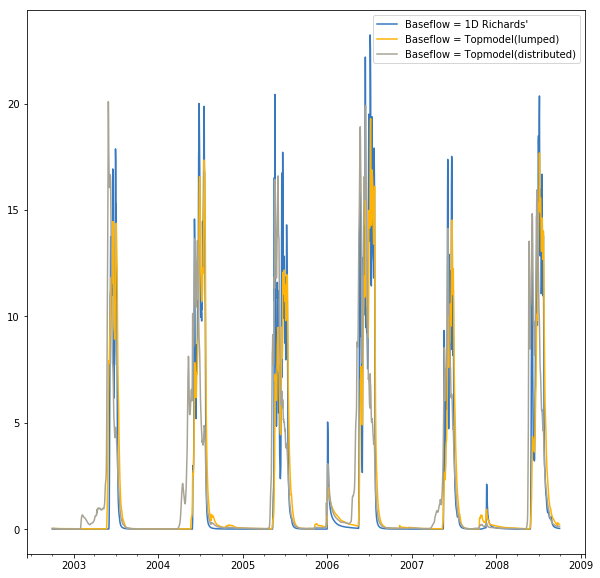

In [268]:
# create plot with the Parameterization of model representation of the lateral flux of liquid water
Runoff_Combine_Graph = Runoff_Combine.plot()
Runoff_Combine_Graph.lines(obs_date, obs_streamflow_daily)

#ET_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'])

# plot scatter with x='xvals', y='Observation (aspen)'
#Runoff_Combine_Graph.fill(dates)#, df_filt['Observation'])
# add x, y label
Runoff_Combine_Graph.set(xlabel='Time of day (day)', ylabel='Runoff (mm/day) ')
# show up the legend
Runoff_Combine_Graph.legend()

## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:

* The simulation in Figure 8 illustrates the model representation of the lateral flux of liquid water, which determines (in part) the availability of soil water.

* The results in Figure 8 demonstrate strong sensitivities the lateral flow parameterization. The parameterizations based on power-law transmissivity profiles (both lumped and distributed) have more drainage of soil water at deeper soil layers; however, the distributed simulations include inflow from upslope, resulting in more plant-available soil water and an increase in transpiration. Taken together, the results in Figure 8 illustrate the strong interdependencies among different modeling decisions, which of course complicate discriminating among competing process parameterizations.